In [136]:
%reset -f
from phi.jax.flow import *
from phi.jax.stax.flow import *
# from phi.tf.flow import *
import numpy as np
import flax.linen as nn
from flax.training import train_state, checkpoints
import optax
import os

#rnd = TF_BACKEND # for phiflow: sample different points in the domain each iteration
rnd = math.choose_backend(1) # use same random points for all iterations
key = jax.random.PRNGKey(1)

2022-12-20 02:12:46.719530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-20 02:12:46.720147: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-20 02:12:46.720167: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [137]:
def network(x, t):
    """ Dense neural network with 8 hidden layers and 3021 parameters in total.
    """
    y = jnp.stack([x, t], axis=-1)
    return dense_net(in_channels=2, out_channels=1, layers=[2]+[20]*8+[1], activation='ReLU', batch_norm=False)(y)

## Small test
x = jnp.zeros((5,5, 1))
t = jnp.ones((5,5, 1))
network(x, t).shape

(5, 5, 1, 1)

In [138]:
class DenseNet(nn.Module):
    @nn.compact
    def __call__(self, x, t):
        inputs = jnp.stack([x, t], axis=-1)
        y = nn.Dense(2)(inputs)
        for i in range(0, 8):
            y = nn.Dense(20)(y)
            y = nn.relu(y)
        return nn.Dense(1)(y)

def init_flax_params(net:nn.Module):
    # init_data = jnp.ones((1,)+net.input_shape)
    init_data = 1., 0.
    params = net.init(key, *init_data)
    print(net.tabulate(key, *init_data, depth=8, console_kwargs={"force_jupyter":False}))
    return params

pinn = DenseNet()
params = init_flax_params(pinn)


                             DenseNet Summary                              
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module   ┃ inputs      ┃ outputs     ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ DenseNet │ - 1.0       │ float32[1]  │                        │
│         │          │ - 0.0       │             │                        │
├─────────┼──────────┼─────────────┼─────────────┼────────────────────────┤
│ Dense_0 │ Dense    │ float64[2]  │ float32[2]  │ bias: float32[2]       │
│         │          │             │             │ kernel: float32[2,2]   │
│         │          │             │             │                        │
│         │          │             │             │ 6 (24 B)               │
├─────────┼──────────┼─────────────┼─────────────┼────────────────────────┤
│ Dense_1 │ Dense    │ float32[2]  │ float32[20] │ bias: float32[20]      │
│         │

In [139]:
def boundary_tx(N):     ## Basically optimal control: Strictly speaking, this is not needed !
    x = np.linspace(-1,1,128)
    # precomputed solution from forward simulation (available on the website: https://physicsbaseddeeplearning.org/physicalloss-code.html)
    u = np.asarray( [0.008612174447657694, 0.02584669669548606, 0.043136357266407785, 0.060491074685516746, 0.07793926183951633, 0.0954779141740818, 0.11311894389663882, 0.1308497114054023, 0.14867023658641343, 0.1665634396808965, 0.18452263429574314, 0.20253084411376132, 0.22057828799835133, 0.23865132431365316, 0.25673879161339097, 0.27483167307082423, 0.2929182325574904, 0.3109944766354339, 0.3290477753208284, 0.34707880794585116, 0.36507311960102307, 0.38303584302507954, 0.40094962955534186, 0.4188235294008765, 0.4366357052408043, 0.45439856841363885, 0.4720845505219581, 0.4897081943759776, 0.5072391070000235, 0.5247011051514834, 0.542067187709797, 0.5593576751669057, 0.5765465453632126, 0.5936507311857876, 0.6106452944663003, 0.6275435911624945, 0.6443221318186165, 0.6609900633731869, 0.67752574922899, 0.6939334022562877, 0.7101938106059631, 0.7263049537163667, 0.7422506131457406, 0.7580207366534812, 0.7736033721649875, 0.7889776974379873, 0.8041371279965555, 0.8190465276590387, 0.8337064887158392, 0.8480617965162781, 0.8621229412131242, 0.8758057344502199, 0.8891341984763013, 0.9019806505391214, 0.9143881632159129, 0.9261597966464793, 0.9373647624856912, 0.9476871303793314, 0.9572273019669029, 0.9654367940878237, 0.9724097482283165, 0.9767381835635638, 0.9669484658390122, 0.659083299684951, -0.659083180712816, -0.9669485121167052, -0.9767382069792288, -0.9724097635533602, -0.9654367970450167, -0.9572273263645859, -0.9476871280825523, -0.9373647681120841, -0.9261598056102645, -0.9143881718456056, -0.9019807055316369, -0.8891341634240081, -0.8758057205293912, -0.8621229450911845, -0.8480618138204272, -0.833706571569058, -0.8190466131476127, -0.8041372124868691, -0.7889777195422356, -0.7736033858767385, -0.758020740007683, -0.7422507481169578, -0.7263049162371344, -0.7101938950789042, -0.6939334061553678, -0.677525822052029, -0.6609901538934517, -0.6443222327338847, -0.6275436932970322, -0.6106454472814152, -0.5936507836778451, -0.5765466491708988, -0.5593578078967361, -0.5420672759411125, -0.5247011730988912, -0.5072391580614087, -0.4897082914472909, -0.47208460952428394, -0.4543985995006753, -0.4366355580500639, -0.41882350871539187, -0.40094955631843376, -0.38303594105786365, -0.36507302109186685, -0.3470786936847069, -0.3290476440540586, -0.31099441589505206, -0.2929180880304103, -0.27483158663081614, -0.2567388003912687, -0.2386513127155433, -0.22057831776499126, -0.20253089403524566, -0.18452269630486776, -0.1665634500729787, -0.14867027528284874, -0.13084990929476334, -0.1131191325854089, -0.09547794429803691, -0.07793928430794522, -0.06049114408297565, -0.0431364527809777, -0.025846763281087953, -0.00861212501518312] );
    t = jnp.ones_like(x) * 0.5
    perm = np.random.permutation(128)
    return (x[perm])[0:N], (t[perm])[0:N], (u[perm])[0:N]

def _ALT_t0(N): # alternative, impose original initial state at t=0
    x = rnd.random_uniform([N], -1, 1)
    t = rnd.zeros_like(x)
    u = - math.sin(np.pi * x)
    return x, t, u

def open_boundary(N):
    t = jax.random.uniform(key, (N,), minval=-1, maxval=1, dtype=jnp.float32)
    x = jnp.concatenate([jnp.zeros((N//2,)) + 1, jnp.zeros((N//2,)) - 1])
    u = jnp.zeros([N])
    return x, t, u

    # t = rnd.random_uniform([N], 0, 1, dtype=math.DType(float, 32))
    # shape = math.spatial(x=N//2)
    # x = math.concat([math.zeros(shape) + 1, math.zeros(shape) - 1], dim=math.spatial('x'))
    # u = math.zeros([N])
    # return x, t, u

In [140]:
def residual(u, x, t):
    """ Physics-based loss function with Burgers equation """
    u_t = gradients(u, t)
    u_x = gradients(u, x)
    u_xx = gradients(u_x, x)
    return u_t + u*u_x - (0.01 / np.pi) * u_xx

In [141]:
N=128
grids_xt = np.meshgrid(np.linspace(-1, 1, N), np.linspace(0, 1, 33), indexing='ij')
grid_x, grid_t = [jnp.array(arr, dtype=jnp.float32) for arr in grids_xt]

# create 4D tensor with batch and channel dimensions in addition to space and time
# in this case gives shape=(1, N, 33, 1)
grid_u = jnp.tile(network(grid_x, grid_t), (1,1,1,1))
grid_u.shape

(1, 128, 33, 1)

Size of grid_u: (1, 128, 33, 1)
Randomly initialized network state:


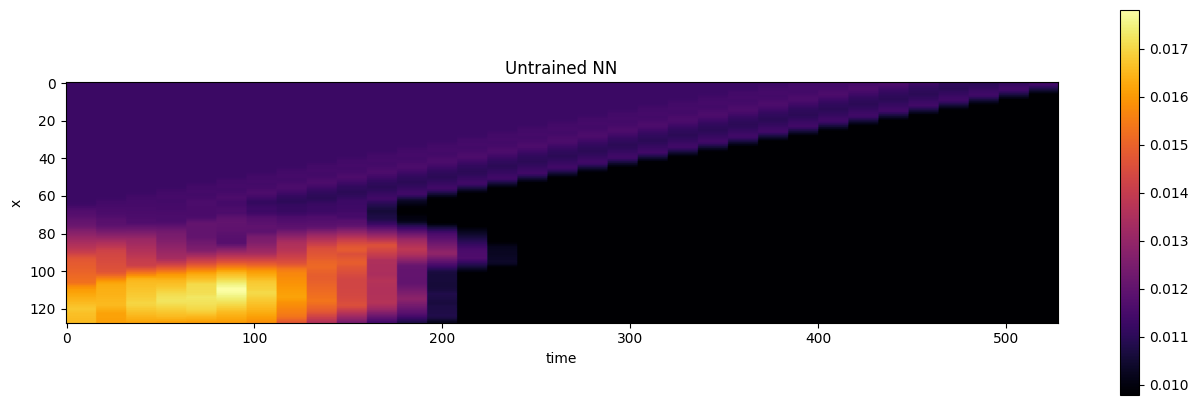

In [142]:
import pylab as plt
print("Size of grid_u: "+format(grid_u.shape))

def show_state(a, title):
    for i in range(4): a = np.concatenate( [a,a] , axis=3)
    a = np.reshape( a, [a.shape[1],a.shape[2]*a.shape[3]] )
    fig, axes = plt.subplots(1, 1, figsize=(16, 5))
    im = axes.imshow(a, origin='upper', cmap='inferno')
    plt.colorbar(im) ; plt.xlabel('time'); plt.ylabel('x'); plt.title(title)

print("Randomly initialized network state:")
show_state(grid_u,"Untrained NN")

In [143]:
# Boundary loss
N_SAMPLE_POINTS_BND = 100
x_bc, t_bc, u_bc = [jnp.concatenate([v_t0, v_t05]) for v_t0, v_t05 in zip(boundary_tx(N_SAMPLE_POINTS_BND), open_boundary(N_SAMPLE_POINTS_BND))]
# x_bc, t_bc, u_bc = np.asarray(x_bc,dtype=np.float32), np.asarray(t_bc,dtype=np.float32) ,np.asarray(u_bc,dtype=np.float32)

# loss_u = math.l2_loss(network(x_bc, t_bc)[:, 0] - u_bc) # normalizes by first dimension, N_bc

# Physics loss inside of domain
N_SAMPLE_POINTS_INNER = 1000
x_ph, t_ph = jax.random.uniform(key, (N_SAMPLE_POINTS_INNER,), minval=-1, maxval=1), jax.random.uniform(key, (N_SAMPLE_POINTS_INNER,), minval=0, maxval=1)

# loss_ph = math.l2_loss(residual(network(x_ph, t_ph)[:, 0], x_ph, t_ph)) # normalizes by first dimension,N_ph

# Combine
# loss = loss_u + 1.00*loss_ph # allows us to control the relative influence of loss_ph

## Optimizer
optimizer = optax.adam(learning_rate=0.02, b1=0.5, b2=0.999)

In [144]:
def loss_fn(params, x_bc, t_bc, u_bc, x_ph, t_ph):
    u_bc_pred = pinn.apply(params, x_bc, t_bc)[:, 0]
    loss_u = math.l2_loss(u_bc_pred- u_bc)

    u_ph_pred = pinn.apply(params, x_ph, t_ph)[:, 0]
    loss_ph = math.l2_loss(residual(u_ph_pred, x_ph, t_ph))

    loss = loss_u + 1.00*loss_ph
    return jnp.mean(loss)

state = train_state.TrainState.create(apply_fn=pinn.apply,
                                        params=params,
                                        tx=optimizer)

In [145]:
@jax.jit
def train_step(state, x_bc, t_bc, u_bc, x_ph, t_ph):
    grads = jax.grad(loss_fn)(state.params, x_bc, t_bc, u_bc, x_ph, t_ph)
    state = state.apply_gradients(grads=grads)
    loss = loss_fn(state.params, x_bc, t_bc, u_bc, x_ph, t_ph)
    return state, loss

@jax.jit
def val_step(state, inputs, targets):
    loss = loss_fn(state.params, inputs, targets)
    return state, loss

history_loss = []

if os.path.isfile("./temp/pinn_checkpoint_"+str(state.step)):
    print("Found existing network, loading & skipping training")
    state = checkpoints.restore_checkpoint(ckpt_dir="./temp/", prefix="net_checkpoint_", target=state)
else:
    print("Training from scratch")
    for epoch in range(10000):
        # net.train()       ##Set network into training mode
        state, loss = train_step(state, x_bc, t_bc, u_bc, x_ph, t_ph)
        # data for graph plotting
        history_loss.append(loss)

        if epoch%20==0:
            print( "Epoch: {} , L2 train: {:7.5f}".format(epoch, loss) )

checkpoints.save_checkpoint("./temp/", prefix="pinn_checkpoint_", target=state, step=state.step, overwrite=True)
print("Training done, saved network")

Training from scratch


NameError: name 'gradients' is not defined